In [ ]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

**Note:** This notebook can run using TensorFlow 2.5.0

In [ ]:
#!pip install tensorflow==2.5.0

In [2]:
import tensorflow as tf
print(tf.__version__)

2.6.0


In [3]:
import numpy as np
import matplotlib.pyplot as plt
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

In [4]:
!wget --no-check-certificate \
    https://raw.githubusercontent.com/jbrownlee/Datasets/master/daily-min-temperatures.csv \
    -O /tmp/daily-min-temperatures.csv

--2021-11-02 18:38:58--  https://raw.githubusercontent.com/jbrownlee/Datasets/master/daily-min-temperatures.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 67921 (66K) [text/plain]
Saving to: ‘/tmp/daily-min-temperatures.csv’

/tmp/daily-min-temp 100%[===================>]  66.33K  --.-KB/s    in 0.005s  

2021-11-02 18:38:58 (12.0 MB/s) - ‘/tmp/daily-min-temperatures.csv’ saved [67921/67921]



In [13]:
test0 = [range(1, 4)]
test1 = np.array(test0)
print(test1)

[[1 2 3]]


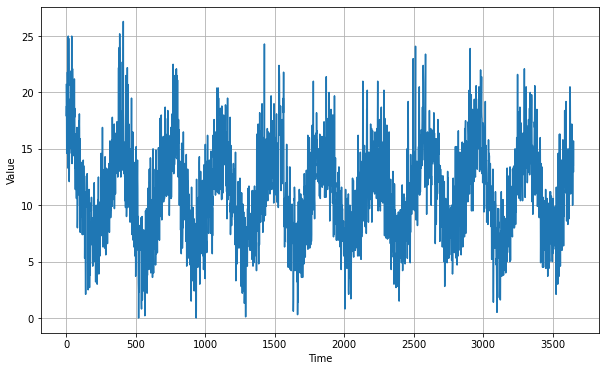

In [19]:
import csv
time_step = []
temps = []

with open('/tmp/daily-min-temperatures.csv') as csvfile:
  reader = csv.reader(csvfile, delimiter = ',')
  time = 1
  next(reader)
  for row in reader:
    temps.append(float(row[1]))
    time_step.append(time)
    time = time + 1

# YOUR CODE HERE. READ TEMPERATURES INTO TEMPS
# HAVE TIME STEPS BE A SIMPLE ARRAY OF 1, 2, 3, 4 etc

series = np.array(temps)
time = np.array(time_step)
plt.figure(figsize=(10, 6))
plot_series(time, series)

In [35]:
split_time = 2500
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

window_size = 30
batch_size = 32
shuffle_buffer_size = 1000


In [45]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[1:]))
    return ds.batch(batch_size).prefetch(1)

In [46]:
def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

In [47]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
window_size = 64
batch_size = 256
train_set = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)
print(train_set)
print(x_train.shape)

model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=60, kernel_size=5, 
                         strides=1, padding="causal",
                         activation="relu", 
                         input_shape=[None, 1]),
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.LSTM(64),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(20, activation="relu"),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x : x * 20)                       
])

lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))
optimizer = tf.keras.optimizers.SGD(learning_rate=1e-8, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])


<PrefetchDataset shapes: ((None, None, 1), (None, None, 1)), types: (tf.float64, tf.float64)>
(2500,)
Epoch 1/100
10/10 [==============================] - 4s 39ms/step - loss: 9.3322 - mae: 9.8307
Epoch 2/100
10/10 [==============================] - 1s 50ms/step - loss: 9.3193 - mae: 9.8178
Epoch 3/100
10/10 [==============================] - 1s 46ms/step - loss: 9.2995 - mae: 9.7979
Epoch 4/100
10/10 [==============================] - 1s 49ms/step - loss: 9.2756 - mae: 9.7741
Epoch 5/100
10/10 [==============================] - 1s 49ms/step - loss: 9.2486 - mae: 9.7471
Epoch 6/100
10/10 [==============================] - 1s 48ms/step - loss: 9.2182 - mae: 9.7167
Epoch 7/100
10/10 [==============================] - 1s 50ms/step - loss: 9.1848 - mae: 9.6833
Epoch 8/100
10/10 [==============================] - 1s 49ms/step - loss: 9.1475 - mae: 9.6460
Epoch 9/100
10/10 [==============================] - 1s 48ms/step - loss: 9.1069 - mae: 9.6054
Epoch 10/100
10/10 [=======================

(1e-08, 0.0001, 0.0, 60.0)

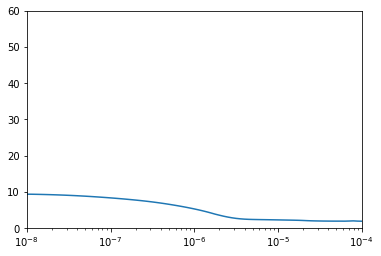

In [48]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-8, 1e-4, 0, 60])

In [50]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
train_set = windowed_dataset(x_train, window_size=60, batch_size=100, shuffle_buffer=shuffle_buffer_size)
model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=60, kernel_size=5, 
                         strides=1, padding="causal",
                         activation="relu", 
                         input_shape=[None, 1]),
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(20, activation="relu"),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x : x * 20) 
])


optimizer = tf.keras.optimizers.SGD(learning_rate=3e-6, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set,epochs=500)
                                    
# EXPECTED OUTPUT SHOULD SEE AN MAE OF <2 WITHIN ABOUT 30 EPOCHS

Epoch 1/500
25/25 [==============================] - 5s 37ms/step - loss: 8.2669 - mae: 8.7644
Epoch 2/500
25/25 [==============================] - 1s 35ms/step - loss: 5.8792 - mae: 6.3691
Epoch 3/500
25/25 [==============================] - 1s 36ms/step - loss: 4.2847 - mae: 4.7645
Epoch 4/500
25/25 [==============================] - 1s 35ms/step - loss: 3.3598 - mae: 3.8311
Epoch 5/500
25/25 [==============================] - 1s 35ms/step - loss: 2.9417 - mae: 3.4070
Epoch 6/500
25/25 [==============================] - 1s 37ms/step - loss: 2.7732 - mae: 3.2367
Epoch 7/500
25/25 [==============================] - 1s 35ms/step - loss: 2.7041 - mae: 3.1671
Epoch 8/500
25/25 [==============================] - 1s 37ms/step - loss: 2.6649 - mae: 3.1273
Epoch 9/500
25/25 [==============================] - 1s 36ms/step - loss: 2.6380 - mae: 3.1000
Epoch 10/500
25/25 [==============================] - 1s 36ms/step - loss: 2.6146 - mae: 3.0763
Epoch 11/500
25/25 [=============================

In [51]:
rnn_forecast = model_forecast(model, series[..., np.newaxis], window_size)
rnn_forecast = rnn_forecast[split_time - window_size:-1, -1, 0]

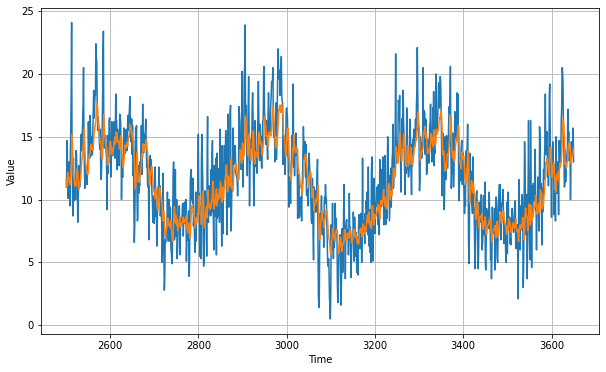

In [52]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, rnn_forecast)

# EXPECTED OUTPUT. PLOT SHOULD SHOW PROJECTIONS FOLLOWING ORIGINAL DATA CLOSELY

In [53]:
tf.keras.metrics.mean_absolute_error(x_valid, rnn_forecast).numpy()

# EXPECTED OUTPUT MAE < 2 -- I GOT 1.789626

1.9073951

In [54]:
print(rnn_forecast)
# EXPECTED OUTPUT -- ARRAY OF VALUES IN THE LOW TEENS

[11.571615 10.999618 11.359244 ... 13.542085 13.635462 14.124937]
